Basic things:

In [1]:
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

Here we create Downloader:

In [289]:
#number of pages to scrape

pages = 20

class Downloader:
    def __init__(self, link):
        self.link = link
        self.uClient = uReq(link)
        self.page_html = self.uClient.read()
        self.uClient.close()
        self.soup = BeautifulSoup(self.page_html, "lxml")
    
    def get_titles(self):
        td = self.soup.findAll('span', {"class":"title"})
        titles = []
        for ind in td:
            # lstrip and rstrip remove symbols from sides, strip removes white spaces
            titles.append(str(ind).lstrip('<span class="title">').rstrip('span>').rstrip('</'))
        return titles
    
    def get_release_dates(self):
        td = self.soup.findAll('div', {"class":"col search_released responsive_secondrow"})
        release_dates = []
        for ind in td:
            if ind.text != "":
            # lstrip and rstrip remove symbols from sides, strip removes white spaces
                release_dates.append(str(ind).rstrip('</div>').split(">")[-1])
            else:
                release_dates.append(None)
        return release_dates
    
    def reviews(self):
   
        td = self.soup.findAll('span', {"class":"search_review_summary positive"})
        reviews = []
        for ind in td:
            # lstrip and rstrip remove symbols from sides, strip removes white spaces
            reviews.append(str(ind).split("html=")[-1])
        return reviews
     
    def get_share_positive_reviews(self):
        text = self.reviews()
        shares = []
        for percent in text:
            shares.append(percent.split("%")[0].split("br&gt;")[1])
        return shares
        
    def get_number_user_reviews(self):  
        text = self.reviews()
        numbers = []
        for number in text:
            start = number.find("of the ") + len("of the ")
            end = number.find(" user reviews")
            numbers.append(number[start:end].replace(",",""))
        return numbers
        
    def get_prices(self):

        td = self.soup.findAll('div', {"class":"col search_price_discount_combined responsive_secondrow"} or 
                          {"class":"col search_price discounted responsive_secondrow"})
        prices = []
        for ind in td:
            if "888888" not in str(ind):
                if (len(str(ind).split("\r\n")[-1].split("</div>\n</div>")[0].strip()) <10):
                    prices.append(str(ind).split("\r\n")[-1].split("</div>\n</div>")[0].strip().replace("€","").replace(",",".").replace("-","0").replace("Free","0"))
            
                else:
                    prices.append(None)
            else:
                start1 = str(ind).find("><strike>") + len("><strike>")
                end1 = str(ind).find("</strike>")
                prices.append(str(ind)[start1:end1].replace("€","").replace(",",".").replace("-","0").replace("Free","0"))
        return prices
    
    def get_price_after_sale(self):

        td = self.soup.findAll('div', {"class":"col search_price_discount_combined responsive_secondrow"} or 
                          {"class":"col search_price discounted responsive_secondrow"})
        sales = []
        for ind in td:
            if "888888" not in str(ind):
                sales.append(None)
            #elif (len(str(ind).split("\r\n")[-1].split("</div>\n</div>")[0].strip()) >10):
                #sales.append(0)
            else:
                sales.append(str(ind).split("br/>")[-1].split("€")[0].replace(",",".").replace("-","0").replace("Free","0").strip())
        return sales
    
    def get_rate_of_sale(self):

        td = self.soup.findAll('div', {"class":"col search_price_discount_combined responsive_secondrow"} or 
                          {"class":"col search_price discounted responsive_secondrow"})
        percent = []
        for ind in td:
            if "888888" not in str(ind):
                percent.append(None)
            else:
                start = str(ind).find(">\n<span>-")+len(">\n<span>-")
                end = str(ind).find("%")
                percent.append(str(ind)[start:end])
        return percent
    
    def dataf(self):
        titles = self.get_titles()
        dates = self.get_release_dates()
        share_reviews = self.get_share_positive_reviews()
        number_reviews = self.get_number_user_reviews()
        normal_prices = self.get_prices()
        sale_price = self.get_price_after_sale()
        sale_rate = self.get_rate_of_sale()
        
        
        self.data = pd.DataFrame({
             'Title': pd.Series(titles),
             'Release date': pd.to_datetime(pd.Series(dates),format='%d %b, %Y', errors = 'coerce'),
             'Share of positive reviews (in %)': pd.to_numeric(share_reviews),
             'Total number of reviews': pd.to_numeric(number_reviews),
             'Normal price (€)': pd.to_numeric(normal_prices),
             'Discounted price if there is a sale (€)': pd.to_numeric(sale_price),
             'Sale rate (in %)': pd.to_numeric(sale_rate)})
        return self.data
   
    def hoarder(self):
        urls = []
        #last_page = int(self.soup.findAll('a',{'class':"search_result_row ds_collapse_flag  app_impression_tracked"})[-1].find('a')['href'][-2:])
        for i in range(pages):
            urls.append(self.link + f"&page={1+i}")
        return urls
    
    def download_data(self):
        urls = self.hoarder()
        Frame = pd.DataFrame()
        for url in urls:
            Frame = Frame.append(pd.DataFrame(data = Downloader(url).dataf()))
        Frame.index = range(pages*25)
        return Frame

Link for scraping:

In [290]:
link = 'https://store.steampowered.com/search/?sort_by=Reviews_DESC&os=win&filter=globaltopsellers'

The dataset from the scraper:

In [291]:
first = Downloader(link)
#first.download() # in order to explore page html in a reasonable way, one can use online javascript beautifier, available at:
# beautifier.io
df = first.download_data()
df

,Title,Release date,Share of positive reviews (in %),Total number of reviews,Normal price (€),Discounted price if there is a sale (€),Sale rate (in %)
0,The Witcher 3: Wild Hunt - Expansion Pass,2015-05-19,99,3350,24.99,NaN,NaN
1,Senren＊Banka,2020-02-14,99,2848,29.99,NaN,NaN
2,Aseprite,2016-02-22,99,2744,14.99,NaN,NaN
3,A Short Hike,2019-07-30,99,2746,6.59,NaN,NaN
4,Doki Doki Literature Club Fan Pack,2017-09-22,99,1498,9.99,NaN,NaN
...,...,...,...,...,...,...,...
495,SHENZHEN I/O,2016-11-17,95,1956,14.99,NaN,NaN
496,The Test,2020-02-24,95,1928,1.59,NaN,NaN
497,Slap City,2018-03-05,95,1908,8.19,NaN,NaN
498,Chroma Squad,2015-04-30,95,1896,12.49,NaN,NaN


Creating a class to summarize the dataset:

In [292]:
class Summary:
    
    def __init__(self, data):
        self.data = data
        
    def n_of_sales(self):
        number = self.data.iloc[:,6].count()
        return print(f'The number of items on sale from the first {pages} pages is {number}.')
    
    def mean_sale(self):
        sales = [int(x) for x in self.data.iloc[:,6].dropna()]
        return print(f'The mean discount is {round(np.mean(sales),2)}%.')
    
    def mean_price_of_sale(self):
        new_price = np.array([x for x in self.data.iloc[:,5].dropna()]).astype(float)
        discount = np.array([x for x in self.data.iloc[:,6].dropna()]).astype(float)
        old_price = new_price/(1-(discount/100))
        return print(f'The average price before sale is {round(np.mean(old_price),2)}€, with the average price after sale being {round(np.mean(new_price),2)}€.')
    
    def average_n_of_reviews(self):
        mean_of_review = round(self.data.iloc[:,3].dropna().mean(),1)
        return print(f'The average number of reviews on a game from the first {pages} pages is {mean_of_review}.')
    
    def price_hist(self):
        new_price = np.array([x for x in self.data.iloc[:,5].dropna()]).astype(float)
        discount = np.array([x for x in self.data.iloc[:,6].dropna()]).astype(float)
        old_price = new_price/(1-(discount/100)) #original prices of items on sale
        #all_prices = np.array([x[:-1].replace(',', '.').replace("-","0") for x in self.data.iloc[:,4].dropna()]).astype(float)
        
        #all_price_hist = pd.Series(all_prices).plot(kind="hist",bins=20, alpha=0.8, figsize=(10,5),color="blue", edgecolor = "red",linewidth=3, label="All prices")
        old_price_hist = pd.Series(old_price).plot(kind="hist",bins=20, alpha=0.8, figsize=(10,5),color="green", edgecolor = "blue",linewidth=3, label = "Prices before discount")
        new_price_hist = pd.Series(new_price).plot(kind="hist",bins=20, alpha=0.8, figsize=(10,5),color="orange", edgecolor = "green",linewidth=3, label = "Discounted Prices")
        
        plt.legend()
        plt.ylabel('Frequency', size='x-large')
        plt.xlabel('$$$', size='x-large')
        return plt.show()
        
    def release_hist(self):
        release = self.data.iloc[:,1].dropna()
        release.groupby(release.dt.year).count().plot(kind="bar", width= 1,color="blue", alpha=0.8, figsize=(10,5), edgecolor = "red",linewidth=3, label = "Release date of items on sale")
        
        plt.legend()
        plt.ylabel('Frequency', size='x-large')
        plt.xlabel('Release date (Year)', size='x-large')
        return plt.show()
    
    def reviews(self):
        sumation = df.groupby('Share of positive reviews (in %)')['Total number of reviews','Normal price (€)','Discounted price if there is a sale (€)'].sum()
        sumation = sumation.rename(columns={'Discounted price if there is a sale (€)': 'Price after sale (€)'}).sort_index(ascending=False)  
        
        counted = df.groupby('Share of positive reviews (in %)')['Total number of reviews','Discounted price if there is a sale (€)'].count()
        counted = counted.rename(columns={'Total number of reviews': 'Number of games', 'Discounted price if there is a sale (€)': 'Number of games on sale'}).sort_index(ascending=False)        
        
        means = df.groupby('Share of positive reviews (in %)')['Total number of reviews','Normal price (€)','Discounted price if there is a sale (€)','Sale rate (in %)'].mean()
        means = means.rename(columns={'Total number of reviews': 'Number of reviews','Discounted price if there is a sale (€)' : 'Discounted price (€)'}).sort_index(ascending=False)  

        return print("Number of the games for each rating: "), print(display(counted)),print() ,print("Total number of the indicators for each score: "), print(display(sumation)),print() ,print("Averages of the indicators for each rating: "), print(display(means.round(1)))
        

Data visualization:

The number of items on sale from the first 20 pages is 15.
The mean discount is 59.13%.
The average price before sale is 14.29€, with the average price after sale being 6.36€.
The average number of reviews on a game from the first 20 pages is 22058.1.


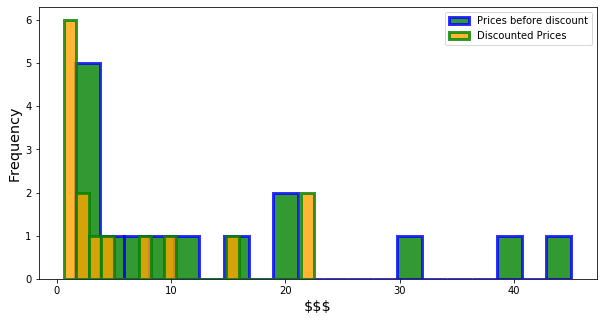

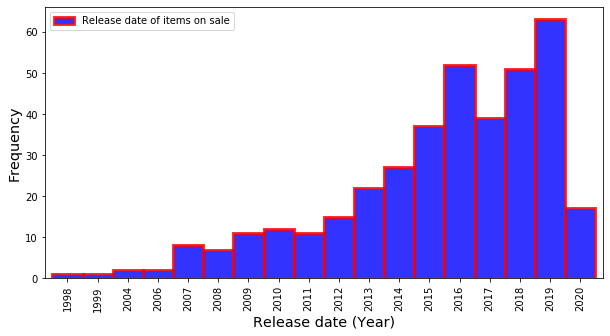

Number of the games for each rating: 


,Number of games,Number of games on sale
Share of positive reviews (in %),,
99,10,0
98,50,2
97,113,7
96,187,2
95,140,4


None

Total number of the indicators for each score: 


,Total number of reviews,Normal price (€),Price after sale (€)
Share of positive reviews (in %),,,
99,17390,146.04,0.00
98,1658893,918.01,3.21
97,1787388,1803.65,57.41
96,4387120,3294.68,5.35
95,3178238,2694.25,29.38


None

Averages of the indicators for each rating: 


,Number of reviews,Normal price (€),Discounted price (€),Sale rate (in %)
Share of positive reviews (in %),,,,
99,1739.0,14.6,NaN,NaN
98,33177.9,18.4,1.6,57.5
97,15817.6,16.0,8.2,53.4
96,23460.5,17.6,2.7,56.0
95,22701.7,19.4,7.3,71.5


None


(None, None, None, None, None, None, None, None)

In [293]:
xx = Summary(df)
xx.n_of_sales()
xx.mean_sale()
xx.mean_price_of_sale()
xx.average_n_of_reviews()
xx.price_hist()
xx.release_hist()
xx.reviews()